>**Submitted By : Md Saif**

>**Roll Number : 200577**

>**Indian Institute of Technology Kanpur**
---





In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:04<00:00, 34582321.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
# Load pre-trained VGG19 model
vgg19 = torchvision.models.vgg19(pretrained=True)

# Modify the last fully connected layer for CIFAR-10 (10 classes)
vgg19.classifier[6] = nn.Linear(4096, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:

torch.save(vgg19.state_dict(), 'vgg19_model.pth')

Epoch [3000/9000]


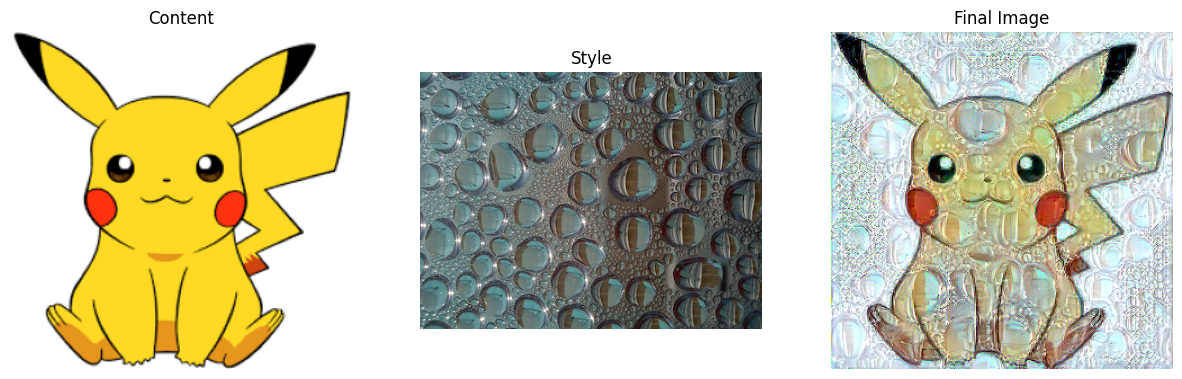

Epoch [6000/9000]


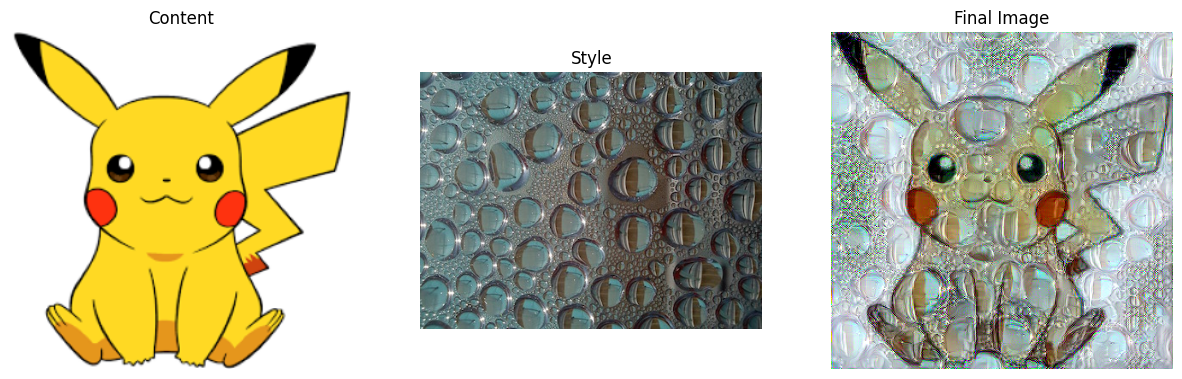

Epoch [9000/9000]


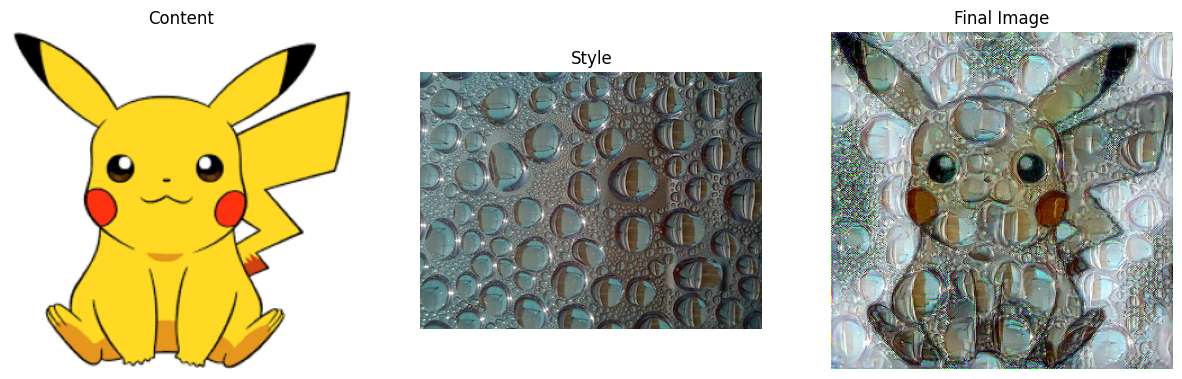

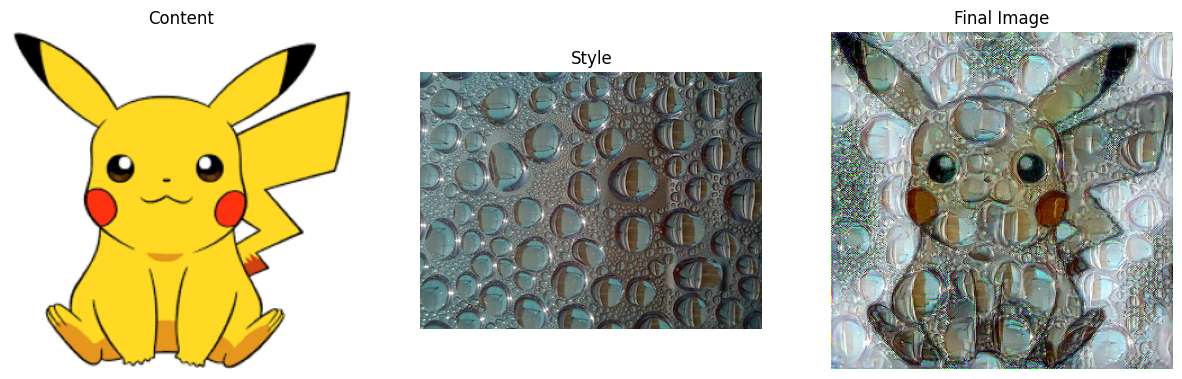

In [28]:
def stylize_image(style_path, content_path):
  # Load the VGG19 model's features
  vgg19 = torchvision.models.vgg19()
  vgg19.classifier[6] = nn.Linear(4096, 10)
  vgg19.load_state_dict(torch.load('vgg19_model.pth'))
  vgg19.eval()
  model = vgg19.features

  # Freeze model parameters
  for p in model.parameters():
      p.requires_grad = False

  # Move the model to the selected device
  model.to(device)

  # Define a function to extract model activations
  def model_activations(input, model):
      layers = {
          '0': 'conv1_1',
          '5': 'conv2_1',
          '10': 'conv3_1',
          '19': 'conv4_1',
          '21': 'conv4_2',
          '28': 'conv5_1'
      }
      features = {}
      x = input.unsqueeze(0)
      for name, layer in model._modules.items():
          x = layer(x)
          if name in layers:
              features[layers[name]] = x
      return features

  # Define the image transformations
  transform = transforms.Compose([
      transforms.Resize(300),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  # Load and preprocess content and style images
  content = Image.open(content_path).convert("RGB")
  content = transform(content).to(device)

  style = Image.open(style_path).convert("RGB")
  style = transform(style).to(device)

  # Clone content for the target and enable gradients
  target = content.clone().requires_grad_(True).to(device)

  def gram_matrix(img_feature):
      _, d, h, w = img_feature.size()
      img_feature = img_feature.view(d, h * w)
      gram_mat = torch.mm(img_feature, img_feature.t())
      return gram_mat

  # Define style weight measurements
  style_wt_meas = {
      "conv1_1": 0.2,
      "conv2_1": 0.2,
      "conv3_1": 0.2,
      "conv4_1": 0.2,
      "conv5_1": 0.2
  }

  # Compute style Gram matrices
  style_features = model_activations(style, model)
  content_features = model_activations(content, model)
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  # Set content and style weights
  content_wt = 0.05
  style_wt = 1e5

  epochs = 9000
  optimizer = torch.optim.Adam([target], lr=0.005)

  def imcnvt(image):
      x = image.to("cpu").clone().detach().numpy().squeeze()
      x = x.transpose(1, 2, 0)
      x = x * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
      return np.clip(x, 0, 1)

  # Define a function to display the image
  def display_image(image, title=None):
      image = imcnvt(image)
      plt.imshow(image)
      if title:
          plt.title(title)
      plt.axis('off')
      plt.show()

  print_every = 3000
  def display_images(content, style, final_image):
      # Display images
      fig, axes = plt.subplots(1, 3, figsize=(15, 5))

      # Display content image
      axes[0].imshow(tensor_to_image(content))
      axes[0].set_title('Content')
      axes[0].axis('off')

      # Display style image
      axes[1].imshow(tensor_to_image(style))
      axes[1].set_title('Style')
      axes[1].axis('off')

      # Display final image
      axes[2].imshow(tensor_to_image(final_image))
      axes[2].set_title('Final Image')
      axes[2].axis('off')

      plt.show()
  # Training loop
  for i in range(1, epochs + 1):
      target_features = model_activations(target, model)
      content_loss = torch.mean((content_features['conv4_2'] - target_features['conv4_2']) ** 2)

      style_loss = 0
      for layer in style_wt_meas:
          style_gram = style_grams[layer]
          target_gram = target_features[layer]
          _, d, w, h = target_gram.shape
          target_gram = gram_matrix(target_gram)
          style_loss += (style_wt_meas[layer] * torch.mean((target_gram - style_gram) ** 2)) / (d * w * h)

      total_loss = content_wt * content_loss + style_wt * style_loss

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      if i % print_every == 0:
              print(f"Epoch [{i}/{epochs}]")
              final_image = target.detach().cpu().squeeze()
              display_images(content, style, final_image)

  # Display content, style, and final image side by side
  display_images(content, style, final_image)
stylize_image("style_image.jpg", "content_image.jpg")

Epoch [3000/9000]


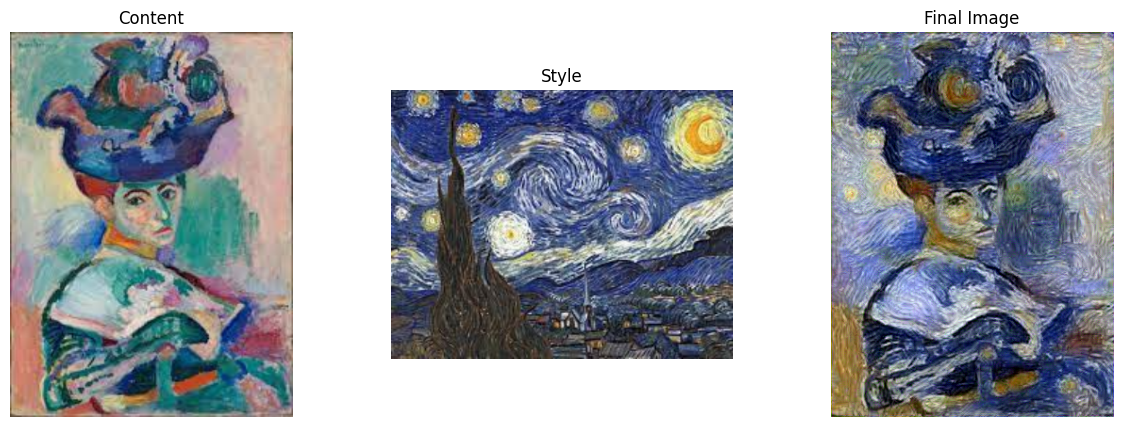

Epoch [6000/9000]


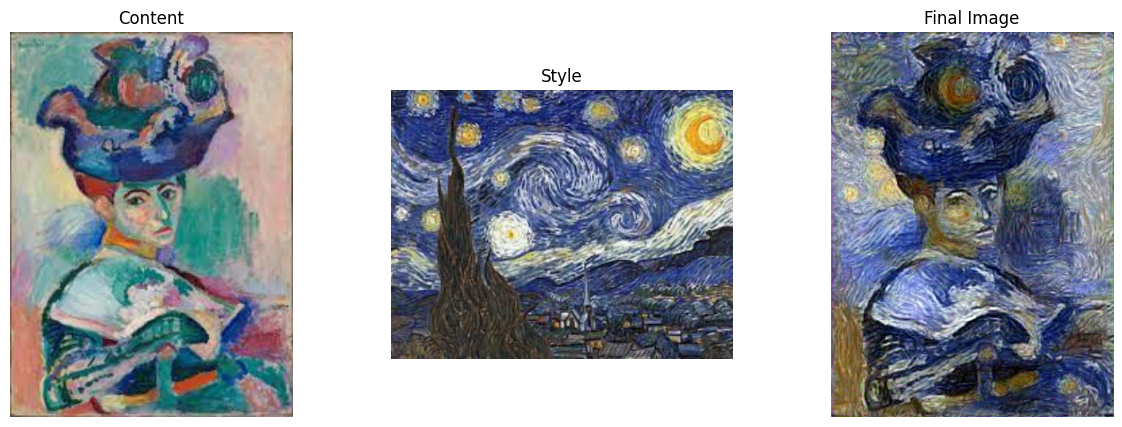

Epoch [9000/9000]


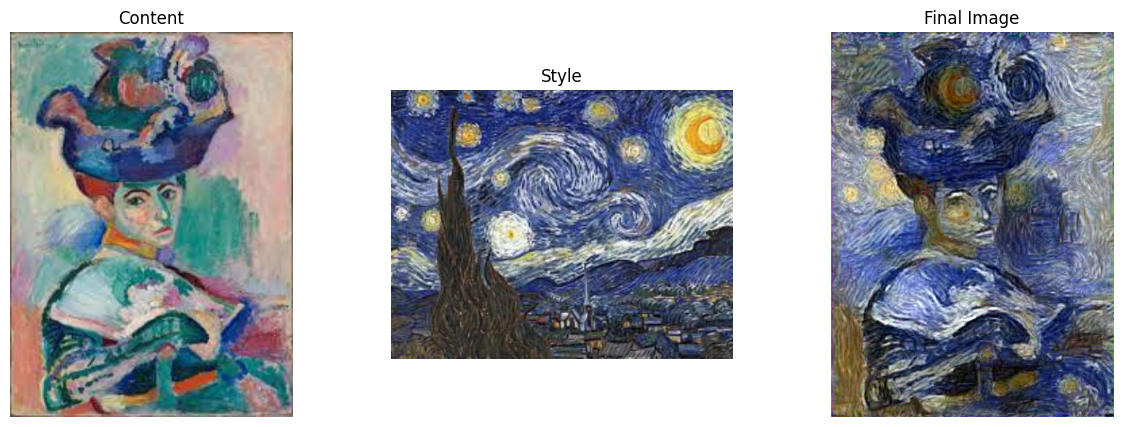

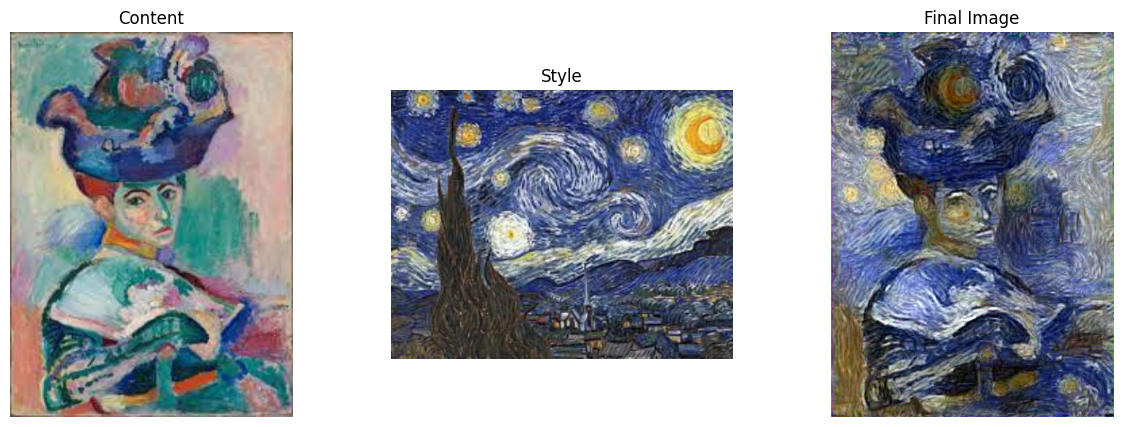

In [30]:
stylize_image("stary.jpg", "woman_with_hat.jpg")